In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/bone-break-classification-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 28.4M/28.4M [00:02<00:00, 12.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pkdarabi/bone-break-classification-image-dataset/versions/4


In [ ]:
import shutil
from pathlib import Path

dest = Path("./data/bone-break")  # your project path
dest.mkdir(parents=True, exist_ok=True)
for item in Path(path).iterdir():
    tgt = dest / item.name
    if item.is_dir():
        shutil.copytree(item, tgt, dirs_exist_ok=True)
    else:
        shutil.copy2(item, tgt)
print("Copied to:", dest)


Copied to: data/bone-break


In [ ]:
!pwd

/content


Picked samples:
- Avulsion fracture: /content/data/bone-break/Bone Break Classification/Bone Break Classification/Avulsion fracture/Train/800px-Left_lateral_malleolus_avulsion_fracture_detail_jpg.rf.9465bfeae560e0d37a57e6096249c030.jpg
- Comminuted fracture: /content/data/bone-break/Bone Break Classification/Bone Break Classification/Comminuted fracture/Train/images32_jpg.rf.745a6cc5974a2c23df2064ac9adeae7d.jpg
- Fracture Dislocation: /content/data/bone-break/Bone Break Classification/Bone Break Classification/Fracture Dislocation/Train/F1-large_jpg.rf.f07b71940901987206be47807d2843ae.jpg
- Greenstick fracture: /content/data/bone-break/Bone Break Classification/Bone Break Classification/Greenstick fracture/Train/Comparison-imaging-of-peric-fracturesg9d8d0f5e1ae7b77ee6efceaf5a1386.jpg
- Hairline Fracture: /content/data/bone-break/Bone Break Classification/Bone Break Classification/Hairline Fracture/Train/bones_what_to_k_732x549_thumb-1-732x549_jpg.rf.9df85dff51f0a0deb0093f75b56d7f16.jpg

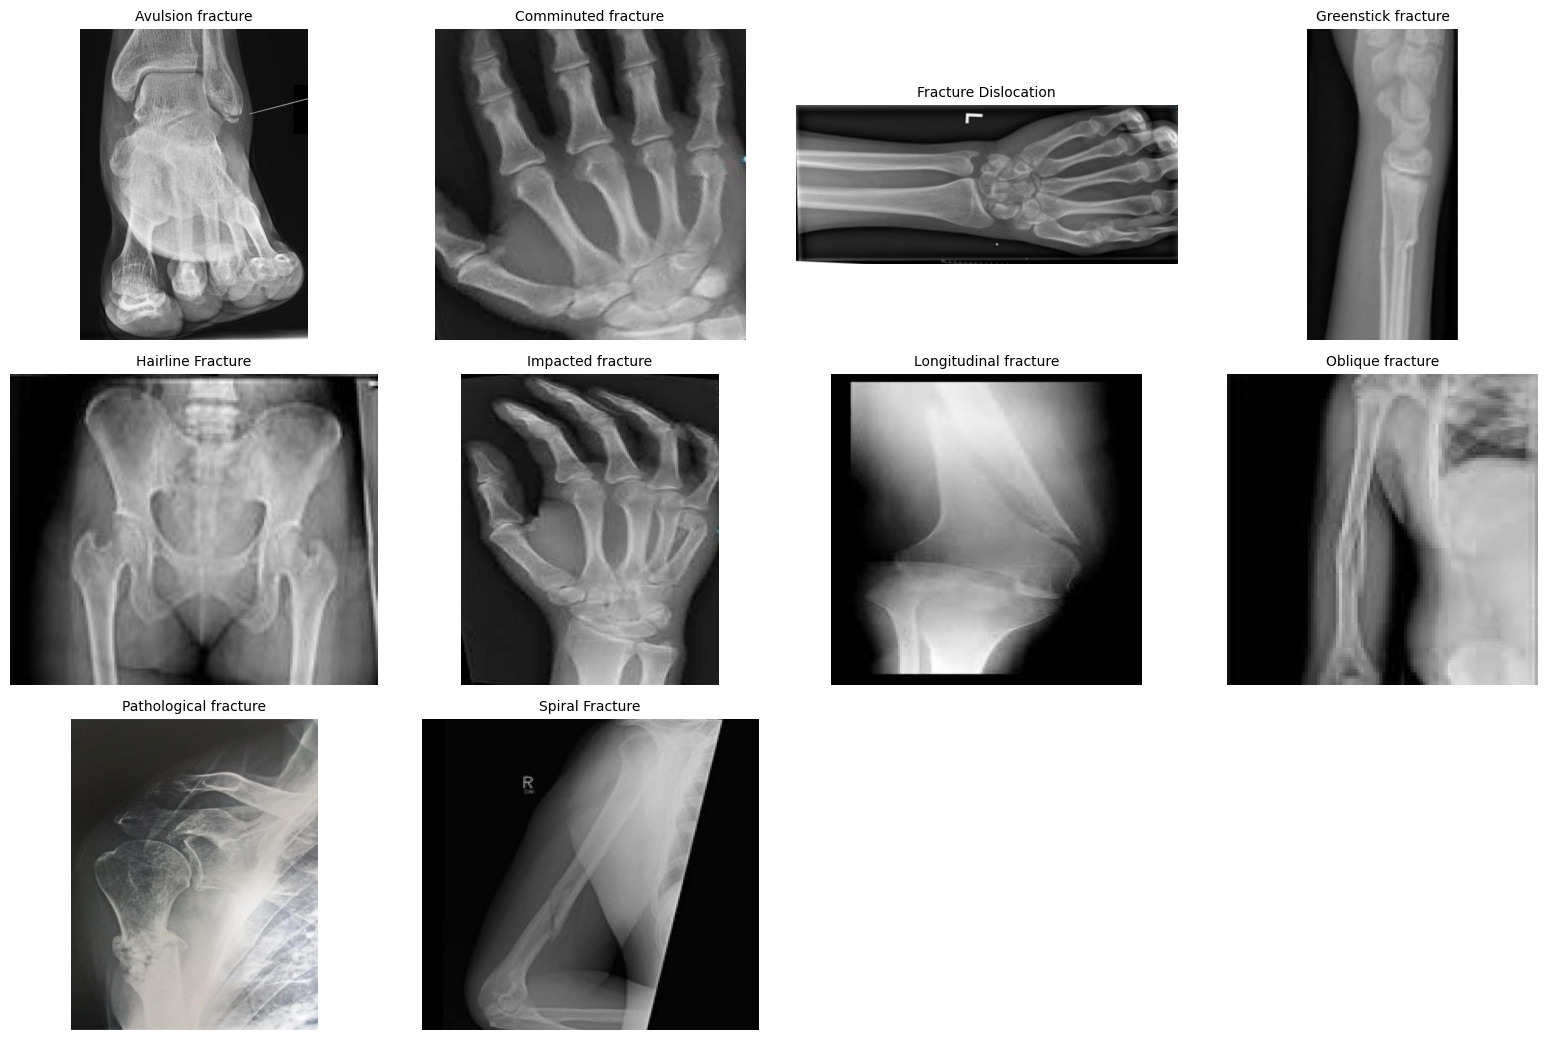

In [ ]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# === Set your root to the folder that CONTAINS all class folders ===
CWD = Path.cwd()  # '/content' in Colab
ROOT = CWD / "data" / "bone-break" / "Bone Break Classification" / "Bone Break Classification"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif"}

def first_image_in(folder: Path):
    for p in folder.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            return p
    return None

samples = []
for class_dir in sorted([d for d in ROOT.iterdir() if d.is_dir()], key=lambda x: x.name.lower()):
    # Prefer a Train/train subfolder if present; else fall back to the class folder
    train_candidate = None
    for name in ("Train", "train"):
        tc = class_dir / name
        if tc.is_dir():
            train_candidate = tc
            break
    search_dir = train_candidate if train_candidate else class_dir

    img_path = first_image_in(search_dir)
    if img_path:
        samples.append((class_dir.name, img_path))

if not samples:
    raise RuntimeError(f"No images found under: {ROOT.resolve()}")

print("Picked samples:")
for cls, p in samples:
    print(f"- {cls}: {p}")

# --- Plot one image per class ---
n = len(samples)
cols = 4
rows = (n + cols - 1) // cols
plt.figure(figsize=(4*cols, 3.5*rows))

for i, (cls, img_path) in enumerate(samples, 1):
    ax = plt.subplot(rows, cols, i)
    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(cls, fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# =========================
# Train ResNet18 + Grad-CAM
# =========================
from pathlib import Path
import random, numpy as np, torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from torchvision import datasets, transforms

# ---------- 1) Paths ----------
CWD = Path.cwd()  # '/content' in Colab
DATA_ROOT = CWD / "data" / "bone-break" / "Bone Break Classification" / "Bone Break Classification"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif"}

def has_images(root: Path) -> bool:
    return any(p.suffix.lower() in IMG_EXTS for p in root.rglob("*") if p.is_file())

class_dirs = [d for d in DATA_ROOT.iterdir() if d.is_dir() and has_images(d)]
classes = sorted(d.name for d in class_dirs)
num_classes = len(classes)

print("num_classes:", num_classes)
print("classes:", classes)
# ---------- 2) Repro ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 3) Transforms ----------
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# ---------- 4) Dataset & split ----------
# ImageFolder will treat each top-level folder (class name) as a class,
# and it RECURSES into subfolders (e.g., Train/...), so your layout works.

full_ds = datasets.ImageFolder(root=str(DATA_ROOT), transform=train_tf)
y = [full_ds.samples[i][1] for i in range(len(full_ds))]  # class indices

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(sss.split(range(len(full_ds)), y))

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(datasets.ImageFolder(root=str(DATA_ROOT), transform=val_tf), val_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


# ---------- 5) Model ----------
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# Replace final FC
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Freeze early layers for faster training
for p in model.layer1.parameters(): p.requires_grad = False
for p in model.layer2.parameters(): p.requires_grad = False

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

# ---------- 6) Train loop (3 epochs for demo) ----------
def evaluate():
    model.eval()
    correct = total = 0
    loss_sum = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss_sum += criterion(logits, y).item() * y.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return loss_sum/total, correct/total

EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
    scheduler.step()
    val_loss, val_acc = evaluate()
    print(f"Epoch {epoch}: val_loss={val_loss:.4f}  val_acc={val_acc:.3f}")


num_classes: 10
classes: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']
Epoch 1: val_loss=2.0703  val_acc=0.336
Epoch 2: val_loss=2.0195  val_acc=0.350
Epoch 3: val_loss=2.0663  val_acc=0.354
Epoch 4: val_loss=1.9844  val_acc=0.420
Epoch 5: val_loss=1.9528  val_acc=0.438
Epoch 6: val_loss=1.9423  val_acc=0.425
Epoch 7: val_loss=1.8687  val_acc=0.442
Epoch 8: val_loss=1.8758  val_acc=0.469
Epoch 9: val_loss=2.0659  val_acc=0.425
Epoch 10: val_loss=2.2077  val_acc=0.363


In [ ]:
print(model)                   # full layer-by-layer structure

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

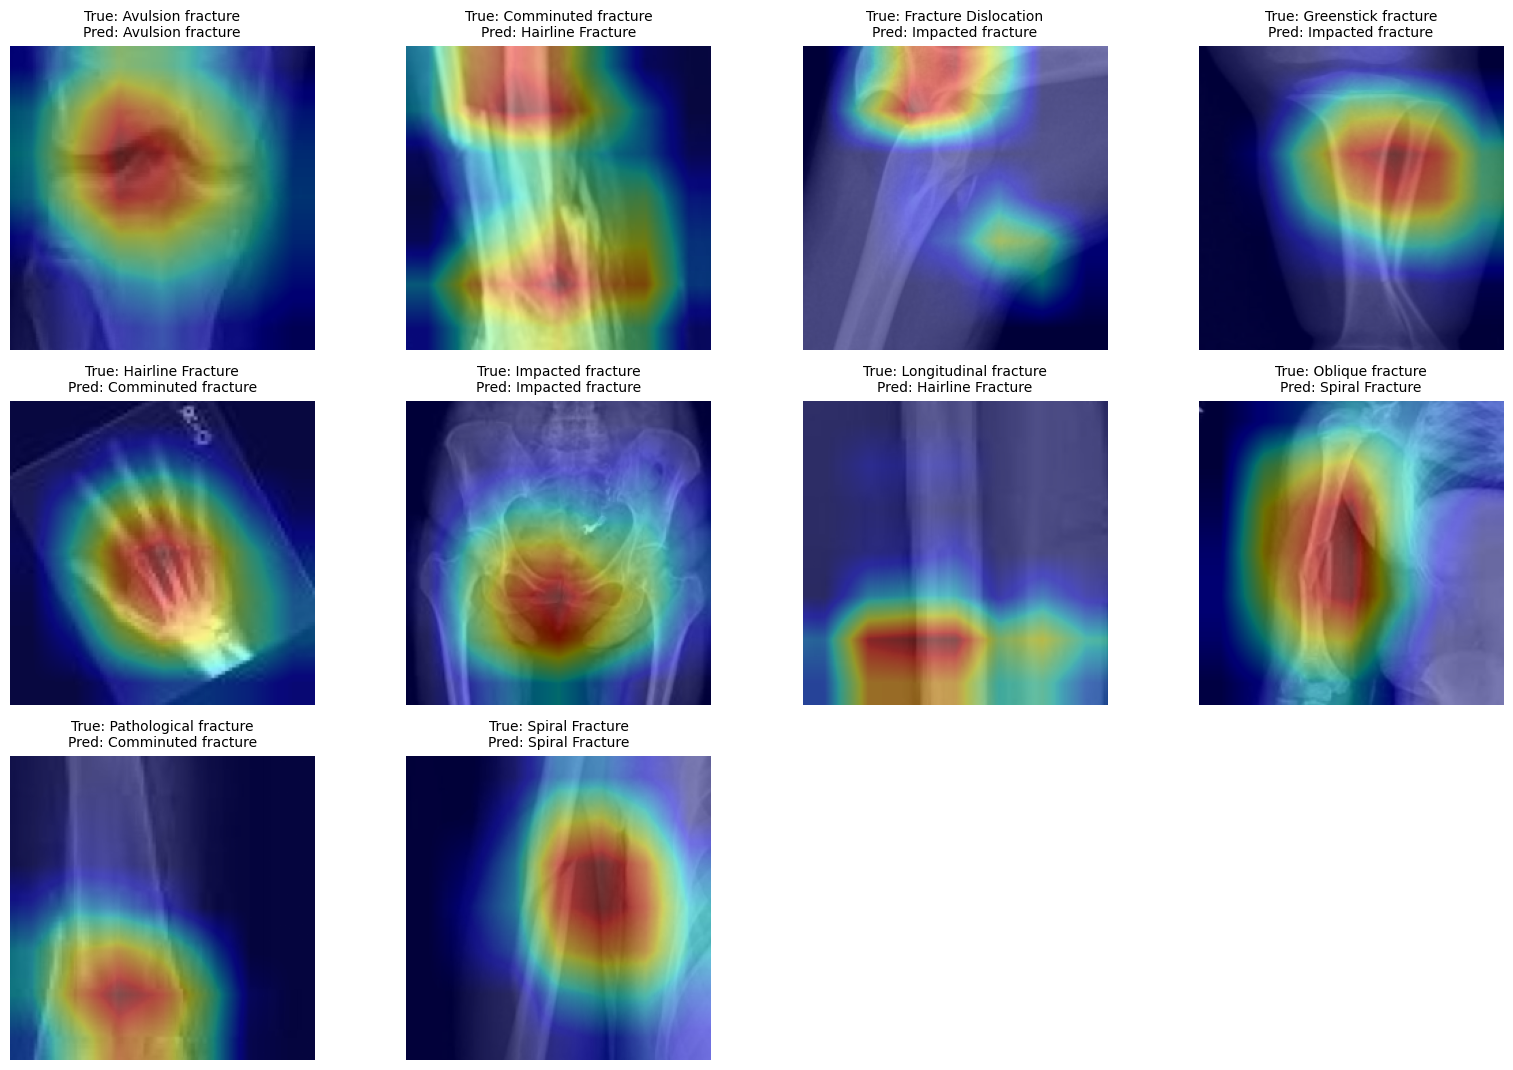

In [ ]:
# =========================
# Grad-CAM
# =========================
# === Grad-CAM: one image per class ===
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

model.eval()
classes = full_ds.classes  # class names in canonical index order
num_classes = len(classes)

# Reusable Grad-CAM (hooks the last conv block of ResNet18)
def grad_cam(model, x, target_layer):
    feats, grads = [], []
    def fwd_hook(m, i, o): feats.append(o)
    def bwd_hook(m, gi, go): grads.append(go[0])

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_full_backward_hook(bwd_hook)

    model.zero_grad(set_to_none=True)
    logits = model(x)
    pred_idx = int(logits.argmax(1))
    score = logits[0, pred_idx]
    score.backward(retain_graph=True)

    A = feats[-1][0].detach()                      # [C,h,w]
    G = grads[-1][0].detach()                      # [C,h,w]
    weights = G.mean(dim=(1,2))                    # [C]
    cam = torch.relu((weights[:,None,None] * A).sum(dim=0))  # [h,w]
    cam = cam / (cam.max() + 1e-8)
    cam_up = F.interpolate(cam[None,None,...], size=x.shape[-2:],
                           mode="bilinear", align_corners=False)[0,0]

    h1.remove(); h2.remove()
    return cam_up.cpu().numpy(), pred_idx

# for pretty images (undo normalization)
def denorm(t):
    mean = torch.tensor([0.485,0.456,0.406])[:, None, None]
    std  = torch.tensor([0.229,0.224,0.225])[:, None, None]
    return (t.cpu()*std + mean).clamp(0,1)

# ---- pick one validation example per class ----
# val_ds is a Subset(ImageFolder(...), val_idx)
one_pos_for_class = {}
for pos in range(len(val_ds)):
    # underlying dataset index
    underlying_i = val_ds.indices[pos]
    # class index from the underlying ImageFolder
    _, cls_idx = val_ds.dataset.samples[underlying_i]
    if cls_idx not in one_pos_for_class:
        one_pos_for_class[cls_idx] = pos
    if len(one_pos_for_class) == num_classes:
        break

# ---- plot a grid with one CAM per class ----
cols = 4
rows = (num_classes + cols - 1) // cols
plt.figure(figsize=(4*cols, 3.6*rows))

for i, cls_idx in enumerate(range(num_classes), start=1):
    pos = one_pos_for_class.get(cls_idx, None)
    if pos is None:
        continue  # no sample for this class in val split

    x_cpu, y_cpu = val_ds[pos]               # normalized tensor, label
    x = x_cpu.unsqueeze(0).to(device)

    cam_up, pred_idx = grad_cam(model, x, model.layer4[-1].conv2)

    img_disp = denorm(x_cpu).permute(1,2,0).numpy()  # HxWx3 in [0,1]

    ax = plt.subplot(rows, cols, i)
    ax.imshow(img_disp)
    ax.imshow(cam_up, cmap="jet", alpha=0.45)
    ax.axis("off")
    ax.set_title(f"True: {classes[cls_idx]}\nPred: {classes[pred_idx]}", fontsize=10)

plt.tight_layout()
plt.show()

Test samples: 140 | #classes: 10
Test accuracy: 0.8571428571428571

Classification report:

                       precision    recall  f1-score   support

    Avulsion fracture      1.000     0.786     0.880        14
  Comminuted fracture      1.000     0.857     0.923        14
 Fracture Dislocation      0.900     0.947     0.923        19
  Greenstick fracture      0.933     0.875     0.903        16
    Hairline Fracture      0.769     1.000     0.870        10
    Impacted fracture      0.778     0.778     0.778         9
Longitudinal fracture      0.588     0.833     0.690        12
     Oblique fracture      0.867     0.812     0.839        16
Pathological fracture      0.867     0.722     0.788        18
      Spiral Fracture      0.923     1.000     0.960        12

             accuracy                          0.857       140
            macro avg      0.862     0.861     0.855       140
         weighted avg      0.874     0.857     0.859       140



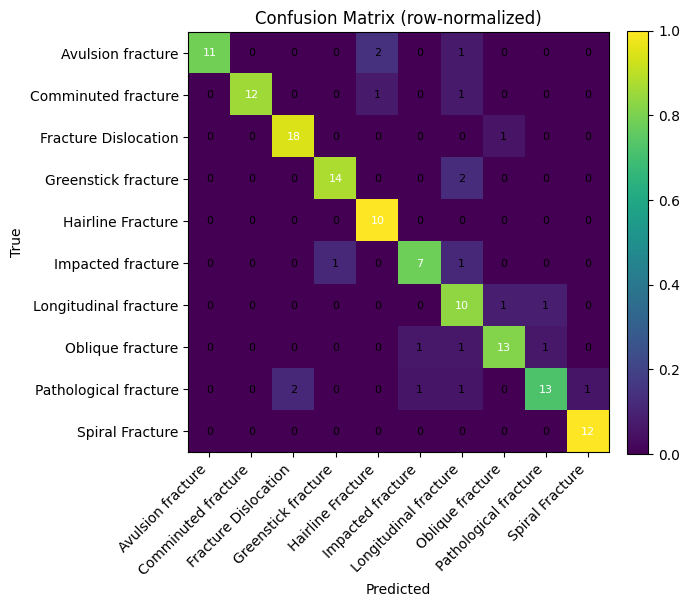

In [ ]:
# ==== Build Test dataset from class/Test subfolders ====
import os
from torchvision import datasets

def is_test_file(path: str) -> bool:
    p = Path(path)
    parts = [s.lower() for s in p.parts]
    return (p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif"}
            and "test" in parts)   # only files inside .../<class>/Test/...

test_tf = val_tf  # same transforms as validation
test_ds = datasets.ImageFolder(root=str(DATA_ROOT), transform=test_tf, is_valid_file=is_test_file)

if len(test_ds) == 0:
    raise RuntimeError(
        f"No test images found. Expected images under '<class>/Test/'. "
        f"Checked under: {DATA_ROOT}"
    )

test_loader = DataLoader(test_ds, batch_size=64, shuffle=False,
                         num_workers=2, pin_memory=torch.cuda.is_available())
classes_test = test_ds.classes  # should match training classes
print(f"Test samples: {len(test_ds)} | #classes: {len(classes_test)}")

# ==== Inference on Test and metrics ====
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(1)
        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(y.cpu().tolist())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

print("Test accuracy:", (all_preds == all_targets).mean())
print("\nClassification report:\n")
print(classification_report(all_targets, all_preds, target_names=classes_test, digits=3))

# ==== Plot confusion matrix (matplotlib-only) ====
cm = confusion_matrix(all_targets, all_preds, labels=list(range(len(classes_test))))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)  # row-normalized

fig, ax = plt.subplots(figsize=(1.0 + 0.6*len(classes_test), 1.0 + 0.6*len(classes_test)))
im = ax.imshow(cm_norm, interpolation='nearest')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_title("Confusion Matrix (row-normalized)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

ax.set_xticks(range(len(classes_test)))
ax.set_yticks(range(len(classes_test)))
ax.set_xticklabels(classes_test, rotation=45, ha="right")
ax.set_yticklabels(classes_test)

# annotate cells
th = cm_norm.max() * 0.6
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        ax.text(j, i, str(val), ha="center", va="center",
                color="white" if cm_norm[i, j] > th else "black", fontsize=8)

plt.tight_layout()
plt.show()

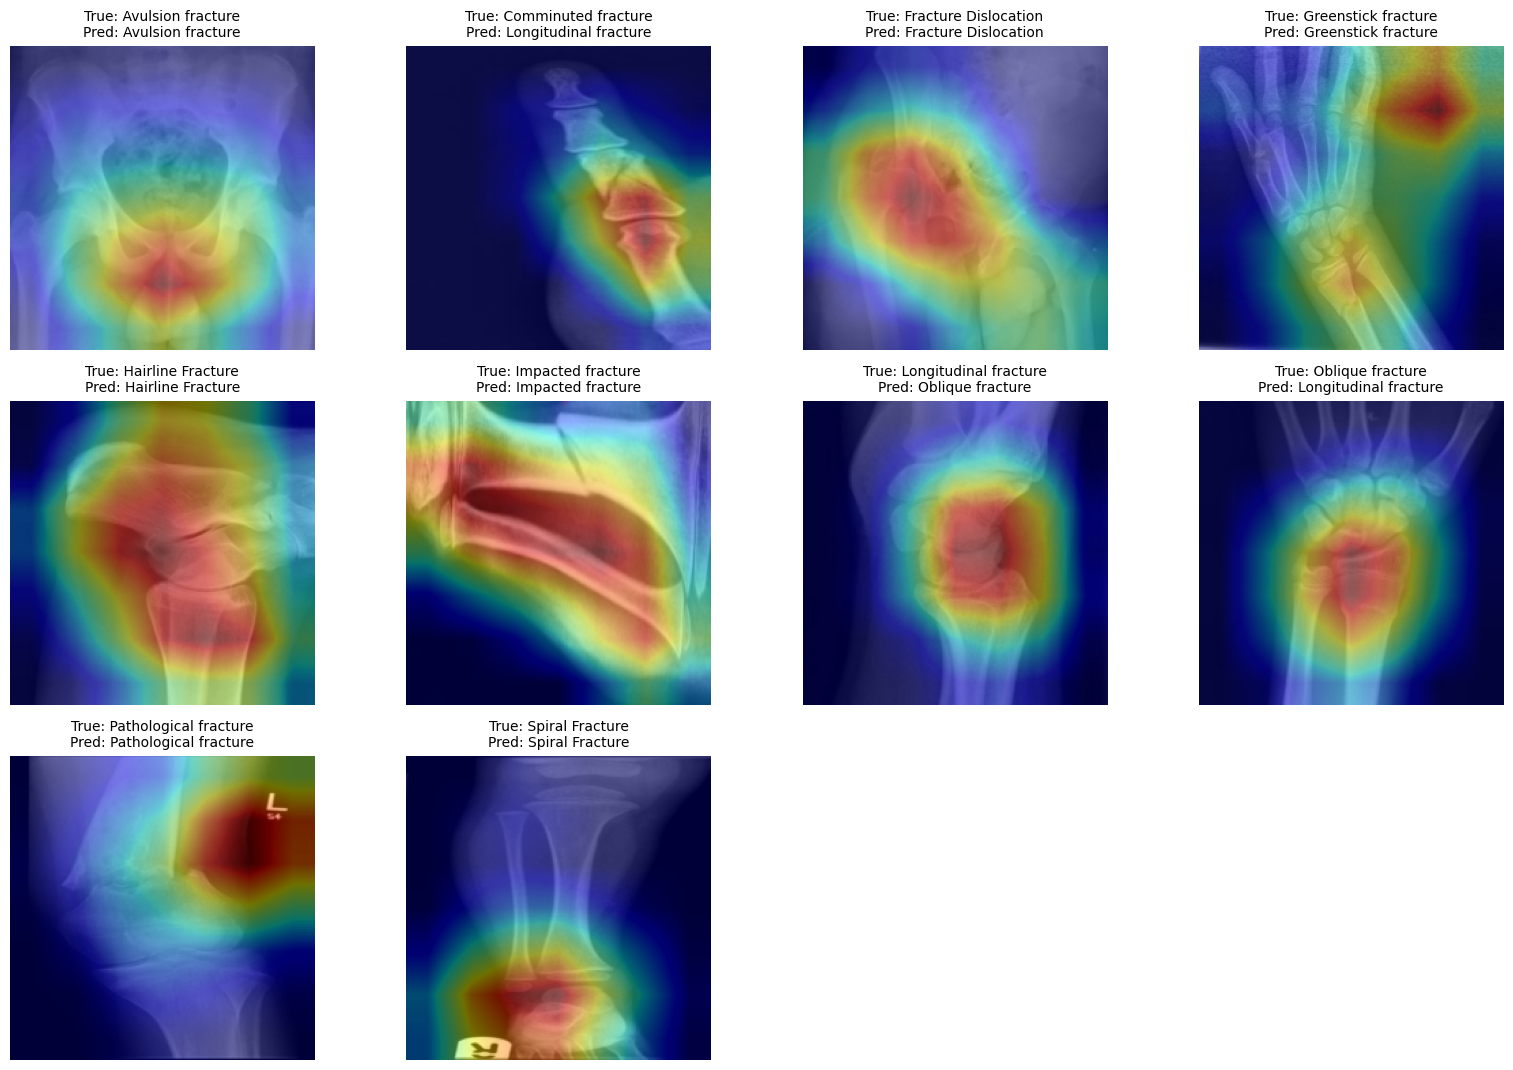

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

model.eval()
classes = test_ds.classes  # should match training order
num_classes = len(classes)

# --- Grad-CAM helper (no OpenCV) ---
def grad_cam(model, x, target_layer):
    feats, grads = [], []
    def fwd_hook(m, i, o): feats.append(o)
    def bwd_hook(m, gi, go): grads.append(go[0])
    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_full_backward_hook(bwd_hook)

    model.zero_grad(set_to_none=True)
    logits = model(x)
    pred_idx = int(logits.argmax(1))
    score = logits[0, pred_idx]
    score.backward(retain_graph=True)

    A = feats[-1][0].detach()                      # [C,h,w]
    G = grads[-1][0].detach()                      # [C,h,w]
    weights = G.mean(dim=(1,2))                    # [C]
    cam = torch.relu((weights[:,None,None] * A).sum(dim=0))  # [h,w]
    cam = cam / (cam.max() + 1e-8)
    cam_up = F.interpolate(cam[None,None,...], size=x.shape[-2:],
                           mode="bilinear", align_corners=False)[0,0]
    h1.remove(); h2.remove()
    return cam_up.cpu().numpy(), pred_idx

# denormalize for display (match your val_tf stats)
def denorm(t):
    mean = torch.tensor([0.485,0.456,0.406])[:, None, None]
    std  = torch.tensor([0.229,0.224,0.225])[:, None, None]
    return (t.cpu()*std + mean).clamp(0,1)

# --- pick one test example per class ---
one_pos_for_class = {}
for i in range(len(test_ds)):
    _, cls_idx = test_ds.samples[i]  # (path, class_idx)
    if cls_idx not in one_pos_for_class:
        one_pos_for_class[cls_idx] = i
    if len(one_pos_for_class) == num_classes:
        break

cols = 4
rows = (num_classes + cols - 1) // cols
plt.figure(figsize=(4*cols, 3.6*rows))

for k, cls_idx in enumerate(range(num_classes), start=1):
    pos = one_pos_for_class.get(cls_idx, None)
    if pos is None:  # no test sample for this class
        continue
    x_cpu, y_cpu = test_ds[pos]  # normalized tensor, label
    x = x_cpu.unsqueeze(0).to(device)

    cam_up, pred_idx = grad_cam(model, x, model.layer4[-1].conv2)
    img_disp = denorm(x_cpu).permute(1,2,0).numpy()

    ax = plt.subplot(rows, cols, k)
    ax.imshow(img_disp)
    ax.imshow(cam_up, cmap="jet", alpha=0.45)
    ax.axis("off")
    ax.set_title(f"True: {classes[cls_idx]}\nPred: {classes[pred_idx]}", fontsize=10)

plt.tight_layout()
plt.show()


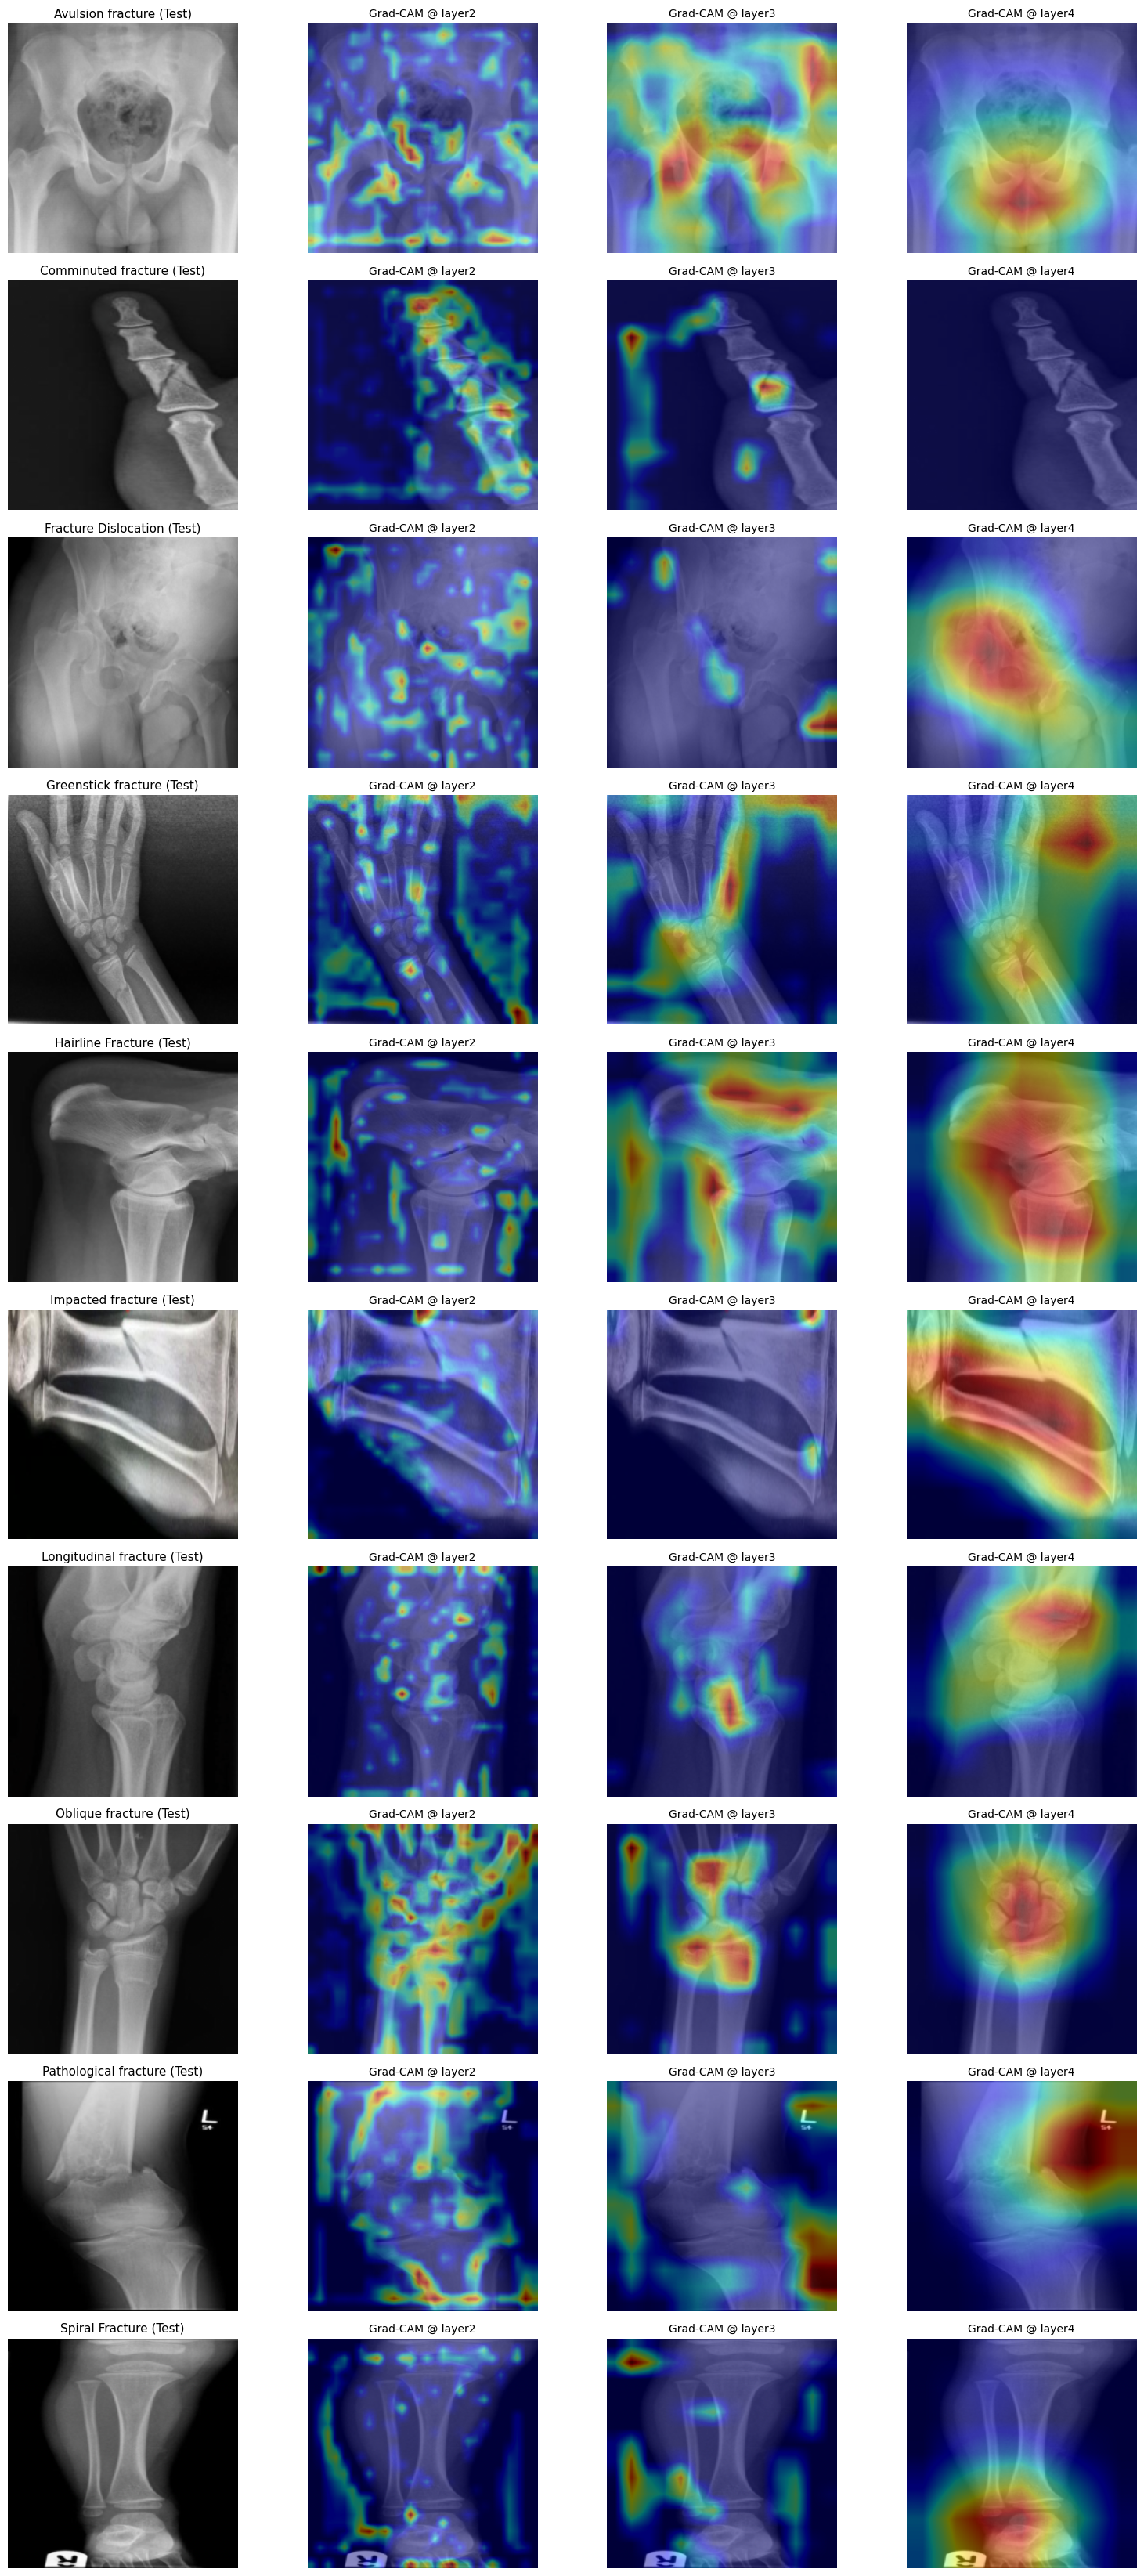

In [ ]:
# ==== One sample per class: Original + CAM@layer2/layer3/layer4 ====
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()

# ---- pick which dataset to visualize from (prefer Test, else Val) ----
try:
    ds = test_ds
    ds_name = "Test"
except NameError:
    ds = val_ds
    ds_name = "Val"

# ---- helpers for Subset(ImageFolder) vs ImageFolder ----
def get_label_at(ds, i):
    if hasattr(ds, "indices"):  # Subset
        base_idx = ds.indices[i]
        return ds.dataset.samples[base_idx][1]
    else:  # ImageFolder
        return ds.samples[i][1]

def get_item_at(ds, i):
    # returns (tensor, label)
    return ds[i]

# canonical class order from training
classes = full_ds.classes
num_classes = len(classes)

# ---- build: one position per class inside ds ----
one_pos_for_class = {}
for i in range(len(ds)):
    y = get_label_at(ds, i)
    if y not in one_pos_for_class:
        one_pos_for_class[y] = i
    if len(one_pos_for_class) == num_classes:
        break

# ---- Grad-CAM core (no OpenCV), target can be y_true or predicted ----
def grad_cam_for(model, x, target_layer, target_idx=None):
    feats, grads = [], []
    def fwd_hook(m, i, o): feats.append(o)
    def bwd_hook(m, gi, go): grads.append(go[0])

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_full_backward_hook(bwd_hook)

    model.zero_grad(set_to_none=True)
    logits = model(x)
    if target_idx is None:
        target_idx = int(logits.argmax(1))
    score = logits[0, int(target_idx)]
    score.backward(retain_graph=True)

    A = feats[-1][0].detach()                     # [C,h,w]
    G = grads[-1][0].detach()                     # [C,h,w]
    weights = G.mean(dim=(1,2))                   # [C]
    cam = torch.relu((weights[:,None,None] * A).sum(dim=0))   # [h,w]
    cam = cam / (cam.max() + 1e-8)
    cam_up = F.interpolate(cam[None,None,...], size=x.shape[-2:], mode="bilinear", align_corners=False)[0,0]

    h1.remove(); h2.remove()
    return cam_up.cpu().numpy(), logits.argmax(1).item()

# denorm for display (match your normalization)
def denorm(t):
    mean = torch.tensor([0.485,0.456,0.406])[:, None, None]
    std  = torch.tensor([0.229,0.224,0.225])[:, None, None]
    return (t.cpu()*std + mean).clamp(0,1)

# ---- choose target layers (finer -> coarser) ----
L2 = model.layer2[-1].conv2
L3 = model.layer3[-1].conv2
L4 = model.layer4[-1].conv2

# ---- plot grid: rows = classes, cols = [Original, L2, L3, L4] ----
cols = 4
rows = num_classes
plt.figure(figsize=(4*cols, 3.3*rows))

row = 0
for cls_idx in range(num_classes):
    pos = one_pos_for_class.get(cls_idx)
    if pos is None:
        # this class has no sample in ds; show empty row headline
        for c in range(cols):
            ax = plt.subplot(rows, cols, row*cols + c + 1); ax.axis("off")
        row += 1
        continue

    x_cpu, y_true = get_item_at(ds, pos)      # normalized tensor and label
    x = x_cpu.unsqueeze(0).to(device)

    # compute CAMs for the TRUE class index (more focused)
    cam2, pred2 = grad_cam_for(model, x, L2, target_idx=int(y_true))
    cam3, pred3 = grad_cam_for(model, x, L3, target_idx=int(y_true))
    cam4, pred4 = grad_cam_for(model, x, L4, target_idx=int(y_true))

    img_disp = denorm(x_cpu).permute(1,2,0).numpy()

    # Original
    ax = plt.subplot(rows, cols, row*cols + 1)
    ax.imshow(img_disp); ax.axis("off")
    ax.set_title(f"{classes[cls_idx]} ({ds_name})", fontsize=11)

    # L2
    ax = plt.subplot(rows, cols, row*cols + 2)
    ax.imshow(img_disp); ax.imshow(cam2, cmap="jet", alpha=0.45)
    ax.axis("off"); ax.set_title("Grad-CAM @ layer2", fontsize=10)

    # L3
    ax = plt.subplot(rows, cols, row*cols + 3)
    ax.imshow(img_disp); ax.imshow(cam3, cmap="jet", alpha=0.45)
    ax.axis("off"); ax.set_title("Grad-CAM @ layer3", fontsize=10)

    # L4
    ax = plt.subplot(rows, cols, row*cols + 4)
    ax.imshow(img_disp); ax.imshow(cam4, cmap="jet", alpha=0.45)
    ax.axis("off"); ax.set_title("Grad-CAM @ layer4", fontsize=10)

    row += 1

plt.tight_layout()
plt.show()


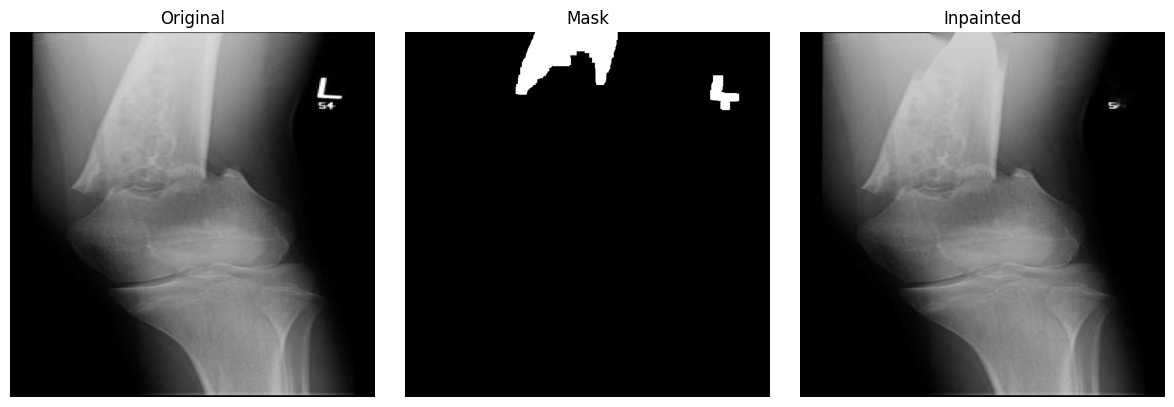

In [ ]:
# Attempt to clean the image

import cv2, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

def remove_corner_labels(pil_img, edge_margin_frac=0.20, bright_pct=98, max_area_frac=0.06, dilate_px=9):
    img = np.array(pil_img.convert("RGB"))
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    thr = np.percentile(gray, bright_pct)                 # top X% brightness
    _, mask = cv2.threshold(gray, thr, 255, cv2.THRESH_BINARY)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)
    keep = np.zeros_like(mask)
    edge_m  = int(edge_margin_frac * min(h, w))           # near-border only
    max_area = int(max_area_frac * h * w)                 # skip huge blobs

    for i in range(1, num):
        x,y,ww,hh,area = stats[i]
        d_edge = min(x, y, w-(x+ww), h-(y+hh))
        if d_edge <= edge_m and area <= max_area:
            keep[labels==i] = 255

    keep = cv2.morphologyEx(keep, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), 1)
    keep = cv2.dilate(keep, np.ones((dilate_px,dilate_px), np.uint8), 1)

    cleaned = cv2.inpaint(img, keep, 3, cv2.INPAINT_TELEA)
    return cleaned, keep

# ---- load your Pathological fracture test image ----
# (Replace with the actual path of that image)
img_path = "/content/data/bone-break/Bone Break Classification/Bone Break Classification/Pathological fracture/Test/0c70d9cb6ae7fcf9faae2dc812af08_gallery_jpg.rf.77bf31aa996b57613189b8de7e1d29fd.jpg"
pil = Image.open(img_path).convert("RGB")

cleaned, mask = remove_corner_labels(
    pil, edge_margin_frac=0.22, bright_pct=98, max_area_frac=0.05, dilate_px=11
)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(pil);     plt.title("Original");      plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(cleaned); plt.title("Inpainted");     plt.axis("off")
plt.tight_layout(); plt.show()


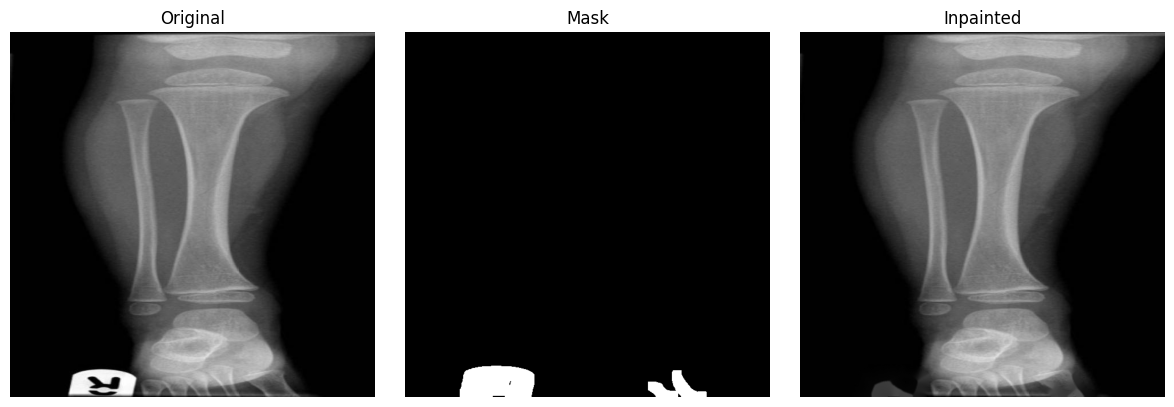

In [ ]:

import cv2, numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def remove_bottom_marker(
    pil_img,
    bottom_frac=0.40,          # analyze only bottom X% of the image
    corner_frac=0.40,          # keep components in left/right X% of width
    max_area_frac=0.10,        # reject huge components
    dilate_px=13,              # grow mask to cover glyph edges
    use_adaptive=True          # adaptive threshold (robust); else Otsu
):
    img = np.array(pil_img.convert("RGB"))
    H, W = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # ---- 1) bottom ROI ----
    y0 = int((1.0 - bottom_frac) * H)
    roi = gray[y0:, :]

    # ---- 2) local threshold (adaptive or Otsu) ----
    if use_adaptive:
        # blockSize must be odd; tune C if needed
        roi_blur = cv2.medianBlur(roi, 5)
        roi_bin = cv2.adaptiveThreshold(
            roi_blur, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
            41, -10  # blockSize, C (negative makes it stricter)
        )
    else:
        thr, roi_bin = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # We want bright blobs; invert if needed
    # If your thresholding produced white = background and black = marker, flip it:
    if np.mean(roi_bin[:5, :5]) > 127:  # crude check
        roi_bin = roi_bin

    # ---- 3) keep connected components that (a) touch the bottom edge,
    #         (b) live in left/right corner bands, and (c) aren't huge ----
    num, labels, stats, _ = cv2.connectedComponentsWithStats(roi_bin, 8)
    mask = np.zeros_like(gray, dtype=np.uint8)
    max_area = int(max_area_frac * H * W)
    corner_band = int(corner_frac * W)

    for i in range(1, num):
        x, y, w, h, area = stats[i]
        touches_bottom = (y + h) >= (roi.shape[0] - 2)
        in_corner = (x + w) <= corner_band or x >= (W - corner_band)
        if touches_bottom and in_corner and area <= max_area:
            comp = (labels == i).astype(np.uint8) * 255
            mask[y0:, :] = np.maximum(mask[y0:, :], comp)

    # ---- 4) tidy mask & dilate ----
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.dilate(mask, np.ones((dilate_px, dilate_px), np.uint8), iterations=1)

    # ---- 5) inpaint ----
    cleaned = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)
    return cleaned, mask

# --- demo on your image path ---
path = "/content/data/bone-break/Bone Break Classification/Bone Break Classification/Spiral Fracture/Test/0-_jumbo_jpeg.rf.7645898c0465d33bcd71ee0ddb847e0a.jpg"
pil = Image.open(path).convert("RGB")
cleaned, mask = remove_bottom_marker(pil)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(pil);     plt.title("Original");  plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(cleaned); plt.title("Inpainted"); plt.axis("off")
plt.tight_layout(); plt.show()


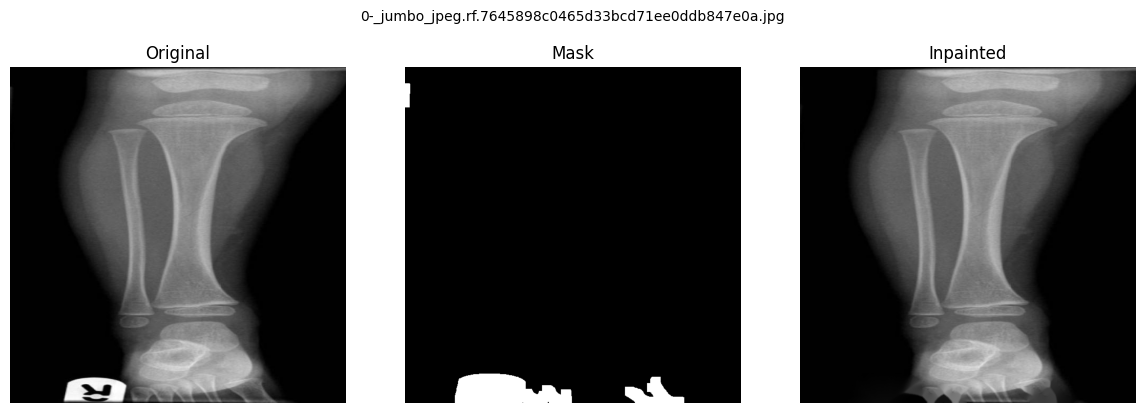

Saved: /content/cleaned/Spiral Fracture/Test/0-_jumbo_jpeg.rf.7645898c0465d33bcd71ee0ddb847e0a.jpg


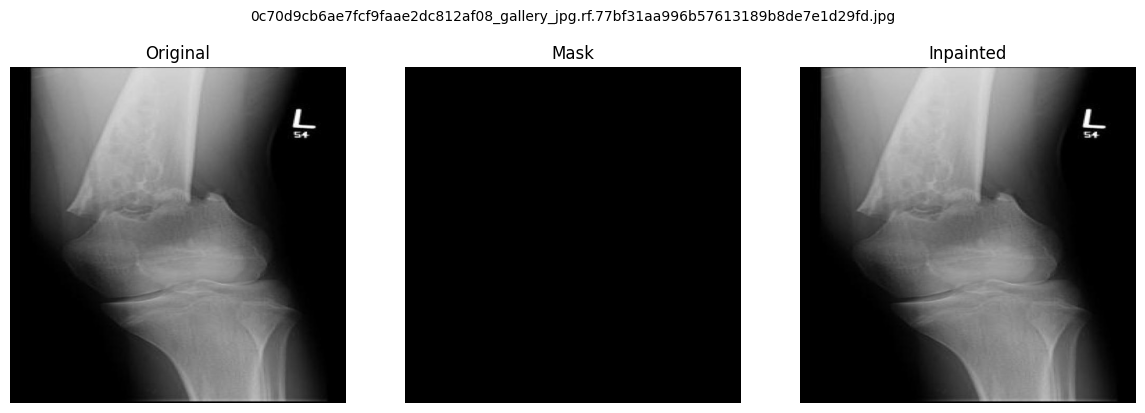

Saved: /content/cleaned/Pathological fracture/Test/0c70d9cb6ae7fcf9faae2dc812af08_gallery_jpg.rf.77bf31aa996b57613189b8de7e1d29fd.jpg


In [ ]:
# If needed:
# !pip install -q opencv-python-headless

import cv2, numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

def _border_component_mask(bin_img, H, W, corner_frac=0.5, max_area_frac=0.08):
    num, labels, stats, _ = cv2.connectedComponentsWithStats(bin_img, 8)
    mask = np.zeros((H, W), np.uint8)
    max_area = int(max_area_frac * H * W)
    corner_band = int(corner_frac * W)
    for i in range(1, num):
        x, y, w, h, area = stats[i]
        touches_border = x <= 1 or y <= 1 or (x+w) >= W-2 or (y+h) >= H-2
        in_corner = (x + w) <= corner_band or x >= (W - corner_band)
        if touches_border and in_corner and area <= max_area:
            mask[labels == i] = 255
    return mask

def remove_markers_auto(
    pil_img,
    bottom_bias=True,          # weight bottom area a bit
    corner_frac=0.5,           # width of corner bands (0..1)
    max_area_frac=0.08,        # reject too-large blobs
    dilate_px=15               # grow mask around glyphs
):
    img = np.array(pil_img.convert("RGB"))
    H, W = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # candidates: adaptive (several), Otsu+CLAHE, percentile
    cand = []
    med = cv2.medianBlur(gray, 5)
    for block, C in [(41, -8), (31, -6), (51, -10)]:
        cand.append(cv2.adaptiveThreshold(med, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, block, C))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(gray)
    _, otsu = cv2.threshold(clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cand.append(otsu)
    p_high = np.percentile(gray, 97 if gray.std() > 25 else 95)
    _, perc = cv2.threshold(gray, int(p_high), 255, cv2.THRESH_BINARY)
    cand.append(perc)

    if bottom_bias:
        y0 = int(0.55 * H)   # bottom ~45%
        rb = cv2.adaptiveThreshold(cv2.medianBlur(gray[y0:, :], 5), 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, -8)
        bmask = np.zeros_like(gray); bmask[y0:, :] = rb
        cand.append(bmask)

    masks = [_border_component_mask(c, H, W, corner_frac=corner_frac, max_area_frac=max_area_frac) for c in cand]
    mask = np.clip(np.sum(masks, axis=0), 0, 255).astype(np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), 1)
    mask = cv2.dilate(mask, np.ones((dilate_px, dilate_px), np.uint8), 1)

    cleaned = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)
    return cleaned, mask

# ---- your two images ----
paths = [
    "/content/data/bone-break/Bone Break Classification/Bone Break Classification/Spiral Fracture/Test/0-_jumbo_jpeg.rf.7645898c0465d33bcd71ee0ddb847e0a.jpg",
    "/content/data/bone-break/Bone Break Classification/Bone Break Classification/Pathological fracture/Test/0c70d9cb6ae7fcf9faae2dc812af08_gallery_jpg.rf.77bf31aa996b57613189b8de7e1d29fd.jpg",
]

src_root = Path("/content/data/bone-break/Bone Break Classification/Bone Break Classification")
dst_root = Path("/content/cleaned")
dst_root.mkdir(parents=True, exist_ok=True)

for p in paths:
    p = Path(p)
    pil = Image.open(p).convert("RGB")
    cleaned, mask = remove_markers_auto(pil, bottom_bias=True, corner_frac=0.5, max_area_frac=0.08, dilate_px=15)

    # show
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(pil);     plt.title("Original");   plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(cleaned); plt.title("Inpainted");  plt.axis("off")
    plt.suptitle(p.name, y=1.02, fontsize=10)
    plt.tight_layout(); plt.show()

    # save to mirrored path under /content/cleaned
    out_path = dst_root / p.relative_to(src_root)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out_path), cv2.cvtColor(cleaned, cv2.COLOR_RGB2BGR))
    print("Saved:", out_path)
